# Setting up a Lagrangian experiment
Requirements:
- [x] Starting from these 32 stations: data/config/stations.csv (1x1 degree boxes)
- [x] start at 4m depth
- [x] 10000 particles per station
- [x] daily release for May-August, 2019-2022 --> managed by job_script
- [x] runtime of 4 weeks
- [x] write hourly snapshots
- [x] track topography

In [1]:
# Import everything required

from parcels import (
    FieldSet,
    JITParticle,
    ScipyParticle,
    ParticleSet,
    AdvectionRK4,
    ErrorCode,
    Variable
)
#import cmocean
from operator import attrgetter
from datetime import datetime, timedelta

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from glob import glob
from shapely.geometry import Polygon, Point
from functools import reduce
import os

## Experiment settings

In [2]:
# release position 
release_depth = 4 #middle of the bottom grid cell of the shallowest station

# release particles
number_particles = 10000

# start date
# Reference date + offset in days. We'll use integer days and argue that due
# to the random spatial seeding, this is largely equivalent to also randomizing 
# seeding times.
start_date_reference = "2019-05-01T00:00:00"
start_date_offset_days = 0

# experiment duration etc
runtime_in_days = 28
dt_in_minutes = 30 
# 1.5km, 0.5m/s --> 3000s & divide by 2 to be on the safe side

# particle positions are stored every x hours 
outputdt_in_hours = 1 

# release location file
release_stations_file = "/gxfs_work/geomar/smomw523/2022_north-sea_oysters/data/config/stations.csv"
release_station = "DK_0044"

# release spread
delta_lat = 0.05
delta_lon = 0.03


# location of input data 
data_path = '/gxfs_work/geomar/smomw529/2022_north-sea_oysters/data/ocean/MetO-NWS-PHY-hi-CUR/'
data_filename = '????/??/*.nc'
example_file = '/gxfs_work/geomar/smomw529/2022_north-sea_oysters/data/ocean/MetO-NWS-PHY-hi-CUR/2022/01/metoffice_foam1_amm15_NWS_CUR_b20220103_hi20220101.nc'


# location of output data
outpath = '/gxfs_work/geomar/smomw523/2022_north-sea_oysters/output_data/revision/'
output_filename_pattern = '{release_station}_start-ref-{start_date_ref:s}_start-offset-{start_date_offset_days:03d}_RT-{runtime_in_days:02d}_N-{number_particles}_depth-{release_depth}m_seed-{RNG_seed}.nc'

# how to initialize the random number generator
RNG_seed = 12345

## Construct input / output paths etc.

In [3]:
file_list = sorted(Path(data_path).glob(data_filename))

outpath = Path(outpath)

output_filename = output_filename_pattern.format(
    release_station=release_station,
    start_date_ref=start_date_reference,
    start_date_offset_days=start_date_offset_days,
    RNG_seed=RNG_seed,
    runtime_in_days=runtime_in_days,
    number_particles=number_particles,
    release_depth=release_depth
)
outfile = outpath / output_filename

In [4]:
outfile

PosixPath('/gxfs_work/geomar/smomw523/2022_north-sea_oysters/output_data/revision/DK_0044_start-ref-2019-05-01T00:00:00_start-offset-000_RT-28_N-10000_depth-4m_seed-12345.nc')

In [5]:
if outfile.exists():
    raise Exception(f"Nothing to do for {outfile}")

Exception: Nothing to do for /gxfs_work/geomar/smomw523/2022_north-sea_oysters/output_data/revision/DK_0044_start-ref-2019-05-01T00:00:00_start-offset-000_RT-28_N-10000_depth-4m_seed-12345.nc

## Load release location

In [6]:
def load_release_locations(release_locations_file):
    df = pd.read_csv(release_locations_file, delimiter="\t")
    df = df.set_index("site_id")
    return df

In [7]:
release_locations = load_release_locations(release_stations_file)
bathymodiolus_lat, bathymodiolus_lon,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_ = release_locations.loc[release_station]

In [8]:
#Central release location
bathymodiolus_lat, bathymodiolus_lon

(56.72285542, 8.199000094)

In [9]:
np.random.seed(RNG_seed)

In [10]:
def get_uniform_random_latlon_in(
    lat_start=bathymodiolus_lat-delta_lat, lat_end=bathymodiolus_lat+delta_lat,
    lon_start=bathymodiolus_lon-delta_lon, lon_end=bathymodiolus_lon+delta_lon,
    N=10,
):
    lat = np.rad2deg(
        np.arcsin(
            np.random.uniform(
                np.sin(np.deg2rad(lat_start)),
                np.sin(np.deg2rad(lat_end)),
                size=(N, ),
            )
        )
    )
    lon = np.random.uniform(lon_start, lon_end, size=(N, ))
    return pd.DataFrame(
        {
            "lat": lat,
            "lon": lon,
        }
    )

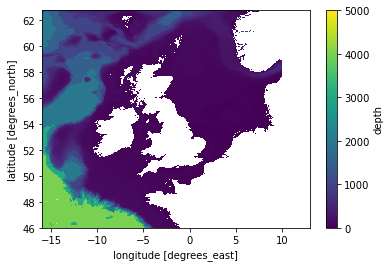

In [11]:
ds_example = xr.open_dataset(example_file)
topo = ds_example.depth.where(~ds_example.uo.isel(time=0, drop=True).isnull()).max("depth") 
topo.plot()

In [12]:
# topography saved in...
#topo=topo.rename('topography')
#topo.to_netcdf('/gxfs_work/geomar/smomw523/2022_north-sea_oysters/data/ocean/topography_northsea.nc')

In [13]:
topo_file = sorted(Path('/gxfs_work/geomar/smomw523/2022_north-sea_oysters/data/ocean').glob('topography_northsea.nc'))
topo_file

[PosixPath('/gxfs_work/geomar/smomw523/2022_north-sea_oysters/data/ocean/topography_northsea.nc')]

In [14]:
release_points = get_uniform_random_latlon_in(N=20*number_particles,
)
release_points["topo"] = topo.sel(
    lat=release_points.to_xarray().lat,
    lon=release_points.to_xarray().lon,
    method="nearest",
)
release_points = release_points.where(release_points.topo > release_depth).dropna().iloc[:number_particles].reset_index(drop=True)

<AxesSubplot:xlabel='lon', ylabel='lat'>

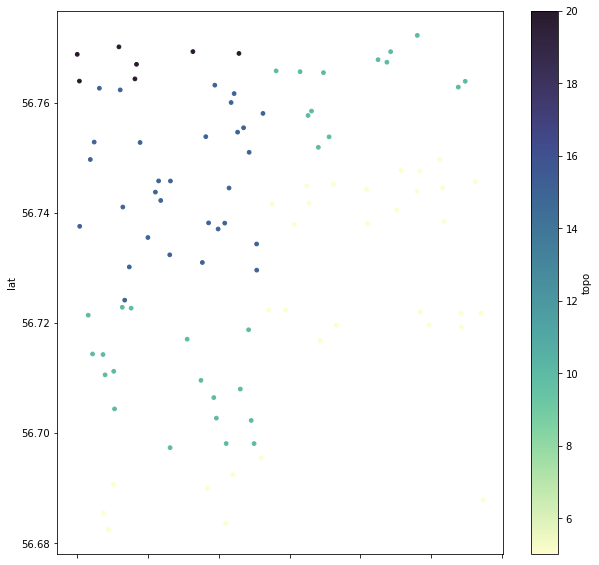

In [15]:
release_points.plot.scatter(x="lon", y="lat", s=14, c="topo", cmap=cmocean.cm.deep, figsize=(10, 10))

## Load input datasets

In [16]:
filenames = {'U': {'lon': file_list[0], 'lat': file_list[0], 'depth': file_list[0], 'data': file_list},
             'V': {'lon': file_list[0], 'lat': file_list[0], 'depth': file_list[0], 'data': file_list},
             'topo': {'lon': file_list[0], 'lat': file_list[0], 'data': topo_file}}
variables = {'U': 'uo', 'V': 'vo', 'topo': 'topography'}
dimensions = {'U': {'lon': 'lon', 'lat': 'lat', 'depth': 'depth', 'time': 'time'},
              'V': {'lon': 'lon', 'lat': 'lat', 'depth': 'depth', 'time': 'time'},
              'topo': {'lon': 'lon', 'lat': 'lat'}}


In [17]:
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, allow_time_extrapolation=True)
fieldset

## Particleset

In [18]:
lat = release_points['lat'][:]
lon = release_points['lon'][:]

depth = np.ones_like(lat) * release_depth 

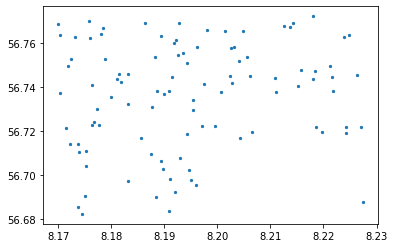

In [19]:
plt.scatter(lon, lat, s=5);

In [20]:
time_origin = np.datetime64(start_date_reference)
time_origin

numpy.datetime64('2019-05-01T00:00:00')

In [21]:
time = (
    time_origin 
    + np.timedelta64(start_date_offset_days, "D") * np.ones_like(lat).astype(int)
)
time[:5]

array(['2019-05-01T00:00:00', '2019-05-01T00:00:00',
       '2019-05-01T00:00:00', '2019-05-01T00:00:00',
       '2019-05-01T00:00:00'], dtype='datetime64[s]')

In [22]:
class SampleParticleInitZero(JITParticle):
    """Define a new particle class with Variable 'topography' init 0"""

    topography = Variable("topography", initial=0)

In [23]:
pset = ParticleSet(
    fieldset=fieldset,
    pclass=SampleParticleInitZero,
    lat=lat,
    lon=lon,
    depth=depth,
    time=time
)

In [24]:
kernel = pset.Kernel(AdvectionRK4)  #2d advection

In [25]:
def SampleT(particle, fieldset, time):  
    particle.topography = fieldset.topo[time, particle.depth, particle.lat, particle.lon]

sample_kernel = pset.Kernel(SampleT)  # Casting the SampleT function to a kernel.

In [26]:
pset.execute(sample_kernel, dt=0)

output_file = pset.ParticleFile(name=f"/gxfs_work/geomar/smomw523/2022_north-sea_oysters/output_data/cache/InitZero_{release_station}_start-ref-{start_date_reference:s}_start-offset-{start_date_offset_days:03d}.nc.zarr", outputdt=timedelta(minutes=dt_in_minutes))

INFO: Compiled ArraySampleParticleInitZeroSampleT ==> /tmp/parcels-726810/lib6465cbc44ee1ce11424c14e774d7155e_0.so


### Be able to handle errors during integration

In [27]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()
    
recovery_cases = {ErrorCode.ErrorOutOfBounds: DeleteParticle,
    ErrorCode.ErrorThroughSurface: DeleteParticle
    }

In [28]:
outfile

PosixPath('/gxfs_work/geomar/smomw523/2022_north-sea_oysters/output_data/revision/DK_0044_start-ref-2019-05-01T00:00:00_start-offset-000_RT-28_N-100_depth-4m_seed-12345.nc')

In [29]:
output_pfile = pset.ParticleFile(name=outfile, outputdt=timedelta(hours=outputdt_in_hours))

In [30]:
pset.execute(
    kernel + sample_kernel,
    runtime=timedelta(days=runtime_in_days),
    dt=timedelta(minutes=dt_in_minutes),
    output_file=output_pfile,
    recovery=recovery_cases,
)

INFO: Compiled ArraySampleParticleInitZeroAdvectionRK4SampleT ==> /tmp/parcels-726810/liba8e6339c815c5d4fbfedcb75e7832fff_0.so
INFO: Temporary output files are stored in /gxfs_work/geomar/smomw523/2022_north-sea_oysters/output_data/revision/out-EZBVAXTG.
INFO: You can use "parcels_convert_npydir_to_netcdf /gxfs_work/geomar/smomw523/2022_north-sea_oysters/output_data/revision/out-EZBVAXTG" to convert these to a NetCDF file during the run.
100%|███████████████████████████| 2419200.0/2419200.0 [17:48<00:00, 2265.03it/s]


In [31]:
output_pfile.export()

In [32]:
particle_ds = xr.open_dataset(outfile)
particle_ds

<xarray.Dataset>
Dimensions:     (traj: 100, obs: 673)
Dimensions without coordinates: traj, obs
Data variables:
    time        (traj, obs) datetime64[ns] ...
    trajectory  (traj, obs) float64 ...
    lon         (traj, obs) float32 ...
    lat         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
    topography  (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

In [33]:
ocean_ds = xr.open_dataset(example_file)
ocean_ds

<xarray.Dataset>
Dimensions:  (time: 24, lat: 1240, lon: 958, depth: 33)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01T01:00:00 ... 2022-01-02
  * lat      (lat) float32 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 -16.0 -15.97 -15.94 -15.91 ... 12.91 12.94 12.97 13.0
  * depth    (depth) float32 0.0 3.0 5.0 10.0 15.0 ... 2e+03 3e+03 4e+03 5e+03
Data variables:
    uo       (time, depth, lat, lon) float32 ...
    vo       (time, depth, lat, lon) float32 ...
Attributes: (12/13)
    title:                hourly-instantaneous horizontal velocity (3D)
    Conventions:          CF-1.7
    source:               PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    contact:              servicedesk.cmems@mercator-ocean.eu
    netcdf-version-id:    netCDF-4
    references:           http://marine.copernicus.eu/
    ...                   ...
    institution:          UK Met Office
    history:              See source and creation_date attributes
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); CMEMS-MERCAT...
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    licence:              http://marine.copernicus.eu/services-portfolio/serv...

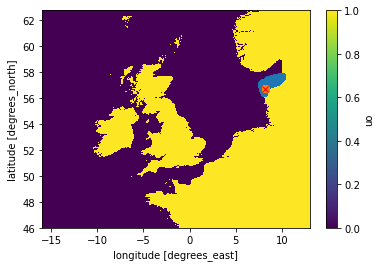

In [34]:
ocean_ds.isel(time=0, depth=1).uo.isnull().plot(x="lon", y="lat")
particle_ds.plot.scatter(x="lon", y="lat")
particle_ds.isel(obs=0).plot.scatter(x="lon", y="lat")
plt.plot(bathymodiolus_lon, bathymodiolus_lat, 'rx')

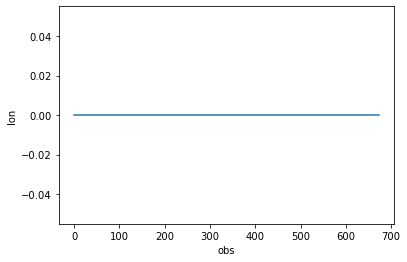

In [35]:
particle_ds.lon.isnull().sum("traj").plot()